# **Imports**

In [2]:
import re, nltk
import numpy as np
import pandas as pd
from textblob import TextBlob
from nltk import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from gensim.models import KeyedVectors
from nltk.stem import WordNetLemmatizer
from keras.preprocessing import sequence
from keras.metrics import Precision, Recall
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Activation, TextVectorization

# **Initialize**

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

In [4]:
df = pd.read_csv('./all-data.csv', encoding='ISO-8859-1')

# **Preprocessing**

In [5]:
# encode (negative, neutral and positive) to (0, 1 and 2)
df['Label'] = LabelEncoder().fit_transform(df['Sentiment'])

# add some words to stopwords
stopwords.words("english").extend(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've',
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat',
                      'de', 're', 'amp', 'will'])

# remove 'not' from stopwords because it affect on polarity of sentences
Stopwords = set(stopwords.words('english')) - set(['not'])

# make lemmatizer instance
lemmatizer = WordNetLemmatizer()

# some preprocessing on text
def preprocess_text(text):
    text = text.replace(r"http\S+"," ")
    text = text.replace(r"http"," ")
    text = text.replace(r"@","at")
    text = text.replace("#[A-Za-z0-9_]+", ' ')
    text = text.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    text = text.lower()
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in Stopwords]
    text = ' '.join(text)
    return text

In [6]:
# remove duplicates sentences
df.drop_duplicates(subset=['Sentence'], keep='first', inplace=True)

# apply preprocessing on sentences
df['Cleaned_sentence'] = df['Sentence'].apply(preprocess_text)

# **Exploratory**

<Axes: xlabel='Sentiment'>

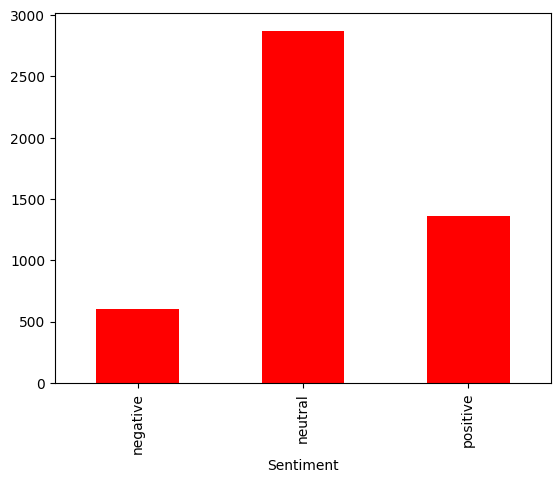

In [11]:
# plot counts of negative, neutral and positive reviews in bar chart
df['Sentiment'].value_counts().reindex(('negative', 'neutral', 'positive')).plot(kind='bar', color='r')

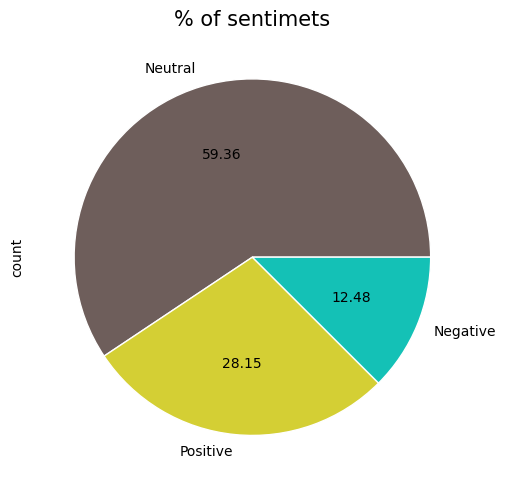

In [14]:
# plot percent of each type of reviews on pie chart
colors = ['#6E5E5B', '#D4CF34', '#14C1B6']
_, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
df.Sentiment.value_counts().plot(kind='pie', labels=('Neutral', 'Positive', 'Negative'), autopct='%.2f', ax=ax1, wedgeprops={ 'linewidth': 1, 'edgecolor': 'white' }, colors=colors)
plt.title('% of sentimets', size=15)
plt.tight_layout()
plt.show()

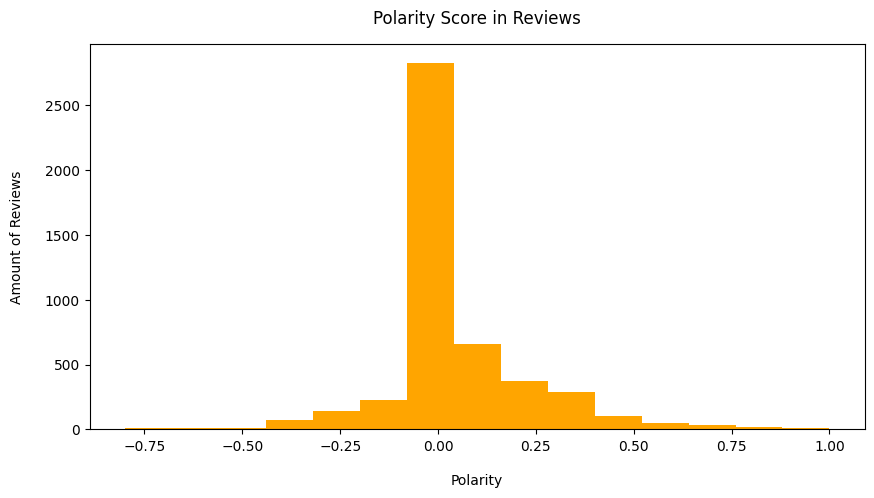

In [15]:
# plot count based on polarity of reviews
df['Polarity'] = df['Cleaned_sentence'].map(lambda Text: TextBlob(Text).sentiment.polarity)
df['Polarity'].plot(kind='hist', bins=15, linewidth=1, color='orange', figsize=(10, 5))
plt.title('Polarity Score in Reviews', pad=15)
plt.xlabel('Polarity', labelpad=15)
plt.ylabel('Amount of Reviews', labelpad=15)
plt.show()

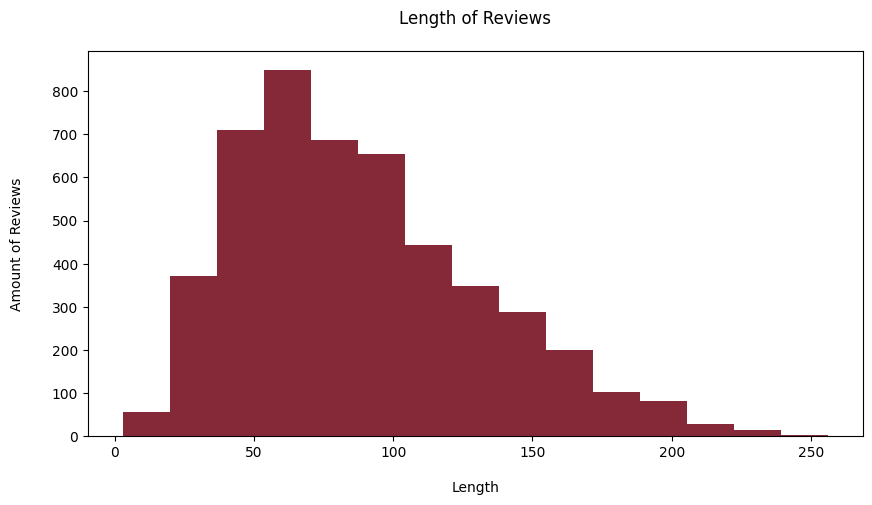

In [16]:
# plot amount of reviews based on length of them
df['Length'] = df['Cleaned_sentence'].astype(str).apply(len)
df['Length'].plot(kind='hist', bins=15, linewidth=1, color='#852938', figsize=(10, 5))
plt.title('Length of Reviews', pad=20)
plt.xlabel('Length', labelpad=15)
plt.ylabel('Amount of Reviews', labelpad=20)
plt.show()

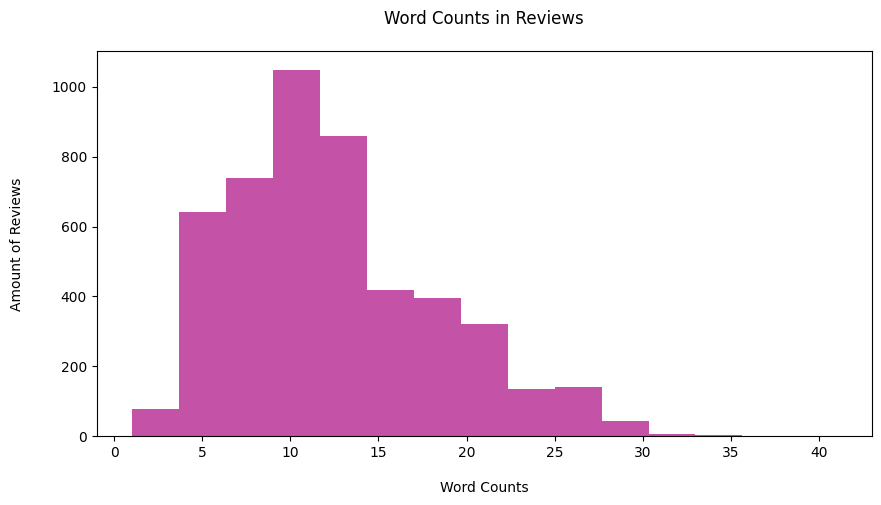

In [17]:
# plot amount of reviews based on word counts
df['Word Counts'] = df['Cleaned_sentence'].apply(lambda x: len(str(x).split()))
df['Word Counts'].plot(kind='hist', bins=15, linewidth=1, color='#C453A7', figsize=(10, 5))
plt.title('Word Counts in Reviews', pad=20)
plt.xlabel('Word Counts', labelpad=15)
plt.ylabel('Amount of Reviews', labelpad=20)
plt.show()

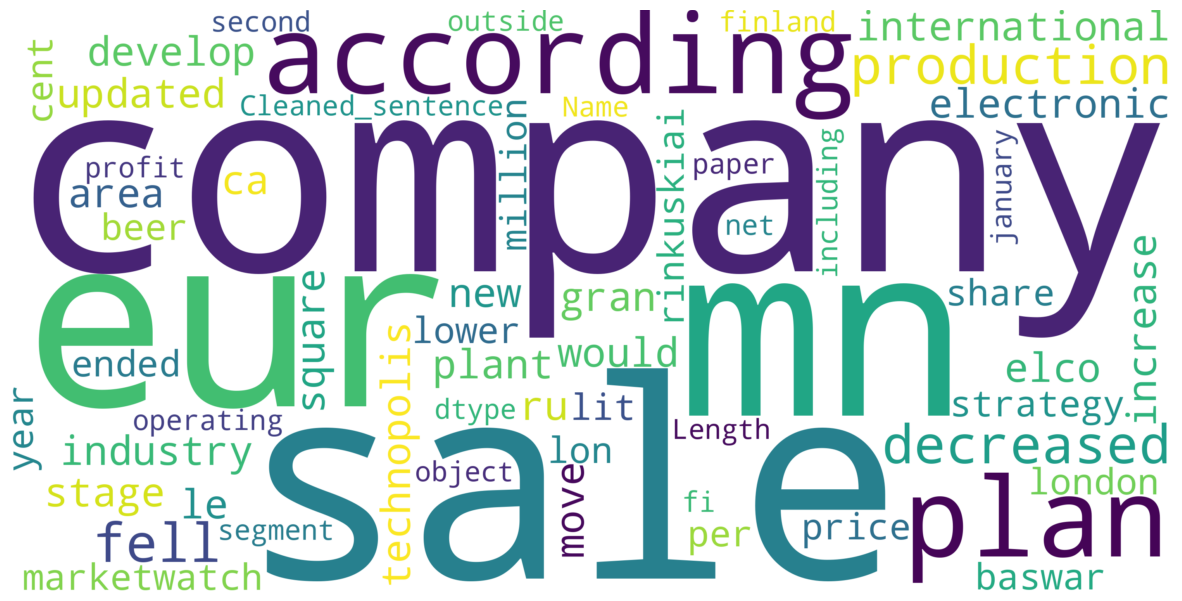

In [18]:
# plot a word cloud from all reviews
wc= WordCloud(background_color='white', random_state=1, max_words=2000, width=3000, height=1500, stopwords=Stopwords).generate(str(df['Cleaned_sentence']))
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Classifications**

**split train and test dataset**

In [ ]:
# split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(np.array(df['Cleaned_sentence']), np.array(df['Label']), test_size=0.20, random_state=42)

# convert each review (sentence) to a tf-idf vector
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize, min_df=0.00002, max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

**RandomForest**

With best parameters:
max_depth            10
min_samples_leaf      1
n_estimators        100
              precision    recall  f1-score   support

    negative       1.00      0.01      0.02       120
     neutral       0.62      1.00      0.76       575
    positive       0.78      0.12      0.20       273

    accuracy                           0.63       968
   macro avg       0.80      0.37      0.33       968
weighted avg       0.71      0.63      0.51       968



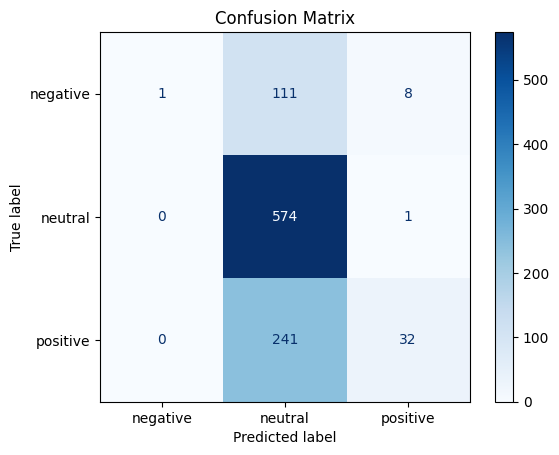

In [20]:
# initialize a RandomForestClassifier with non zero random_state
rf = RandomForestClassifier(random_state=42)

# check different parameters and choose best of them (using grid search)
parameters = {
    'n_estimators' : [100, 200, 300, 400],
    'max_depth' : [3, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}
gs = GridSearchCV(rf, parameters, cv=3)
gs.fit(X_train_tf, y_train)

# set best parameters for random forest classifier
rf.set_params(**gs.best_params_)

# train model
rf.fit(X_train_tf, y_train)

# test model
y_pred = rf.predict(X_test_tf)

# get reports and plot confusion matrix
cr = classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=('negative', 'neutral', 'positive'))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('negative', 'neutral', 'positive'))
print('With best parameters:')
print(pd.Series(gs.best_params_).to_string())
print(cr)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**XGBoost**

With best parameters:
learning_rate    0.1
              precision    recall  f1-score   support

    negative       0.76      0.39      0.52       120
     neutral       0.75      0.93      0.83       575
    positive       0.70      0.49      0.58       273

    accuracy                           0.74       968
   macro avg       0.73      0.60      0.64       968
weighted avg       0.73      0.74      0.72       968



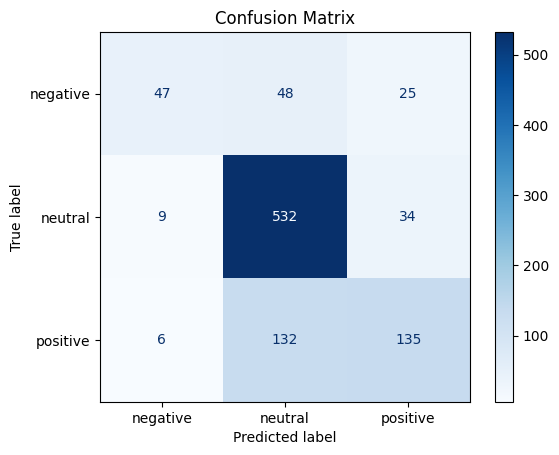

In [21]:
# initialize a XGBClassifier with non zero random_state
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# check different parameters and choose best of them (using grid search)
parameters = { 'learning_rate': [0.001, 0.01, 0.1, 1] }
gs = GridSearchCV(xgb, parameters, cv=3)
gs.fit(X_train_tf, y_train)

# set best parameters for random forest classifier
xgb.set_params(**gs.best_params_)

# train model
xgb.fit(X_train_tf, y_train)

# test model
y_pred = xgb.predict(X_test_tf)

# get reports and plot confusion matrix
cr = classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=('negative', 'neutral', 'positive'))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('negative', 'neutral', 'positive'))
print('With best parameters:')
print(pd.Series(gs.best_params_).to_string())
print(cr)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# **Neural Network**

In [31]:
# a function for plotting precision, recall, accuracy and loss of training epochs
def plot_training_hist(history):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    # find precision and recall keys
    precision_key = list(filter(lambda v: re.match(r'precision_\d+|precision', v), history.history.keys()))[0]
    recall_key = list(filter(lambda v: re.match(r'recall_\d+|recall', v), history.history.keys()))[0]
    # first plot
    ax[0, 0].plot(history.history['accuracy'])
    ax[0, 0].plot(history.history['val_accuracy'])
    ax[0, 0].set_title('Model Accuracy')
    ax[0, 0].set_xlabel('epoch')
    ax[0, 0].set_ylabel('accuracy')
    ax[0, 0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[0, 1].plot(history.history[precision_key])
    ax[0, 1].plot(history.history[f'val_{precision_key}'])
    ax[0, 1].set_title('Model Precision')
    ax[0, 1].set_xlabel('epoch')
    ax[0, 1].set_ylabel('precision')
    ax[0, 1].legend(['train', 'validation'], loc='best')
    #third plot
    ax[1, 0].plot(history.history[recall_key])
    ax[1, 0].plot(history.history[f'val_{recall_key}'])
    ax[1, 0].set_title('Model Recall')
    ax[1, 0].set_xlabel('epoch')
    ax[1, 0].set_ylabel('recall')
    ax[1, 0].legend(['train', 'validation'], loc='best')
    #fourth plot
    ax[1, 1].plot(history.history['loss'])
    ax[1, 1].plot(history.history['val_loss'])
    ax[1, 1].set_title('Model Loss')
    ax[1, 1].set_xlabel('epoch')
    ax[1, 1].set_ylabel('loss')
    ax[1, 1].legend(['train', 'validation'], loc='best')
    plt.tight_layout(h_pad=2.0, w_pad=2.0)

In [23]:
wv = KeyedVectors.load('/content/drive/MyDrive/University/word2vec-google-news-300.bin')
wv_dict = dict(zip(wv.key_to_index.keys(),  wv.vectors))

In [24]:
# split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.Cleaned_sentence, df.Label, test_size=0.2, random_state=42)

# convert y value to correspond index in a 3D array
y_train_enc = to_categorical(y_train, 3)
y_test_enc = to_categorical(y_test, 3)

In [25]:
# Define the TextVectorization layer
vectorizer = TextVectorization(output_mode='int', output_sequence_length=None)

# Adapt the vectorizer to the training and test data
vectorizer.adapt(list(X_train) + list(X_test))

# Transform the texts into sequences
xtrain_seq = vectorizer(X_train)
xtest_seq = vectorizer(X_test)

# Pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq)
xtest_pad = sequence.pad_sequences(xtest_seq)

# Get the word index
word_index = {word: idx for idx, word in enumerate(vectorizer.get_vocabulary())}

In [26]:
# create an embedding matrix from words in dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = wv_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
# create and compile model
# initializes a Sequential model
model = Sequential()

# this layer converts input words into dense vectors of fixed size
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False))

# layer randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting.
model.add(SpatialDropout1D(0.3))

# LSTM layer with 300 LSTM units
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

# connect layers and 80% of the neurons will be randomly set to zero during training.
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.8))

# output a vector of 3 values (probability of each classes)
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [28]:
# training model
history = model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=20, verbose=1, validation_data=(xtest_pad, y_test_enc))

Epoch 1/20
8/8 [==============================] - 22s 2s/step - loss: 1.0155 - accuracy: 0.5690 - precision: 0.6018 - recall: 0.2054 - val_loss: 0.9373 - val_accuracy: 0.5940 - val_precision: 0.6648 - val_recall: 0.1250
Epoch 2/20
8/8 [==============================] - 19s 2s/step - loss: 0.8901 - accuracy: 0.6111 - precision: 0.6745 - recall: 0.4664 - val_loss: 0.8290 - val_accuracy: 0.6477 - val_precision: 0.6926 - val_recall: 0.5610
Epoch 3/20
8/8 [==============================] - 18s 2s/step - loss: 0.8295 - accuracy: 0.6419 - precision: 0.6898 - recall: 0.5452 - val_loss: 0.8208 - val_accuracy: 0.6426 - val_precision: 0.6832 - val_recall: 0.5702
Epoch 4/20
8/8 [==============================] - 18s 2s/step - loss: 0.7818 - accuracy: 0.6434 - precision: 0.7072 - recall: 0.5605 - val_loss: 0.7710 - val_accuracy: 0.6333 - val_precision: 0.6997 - val_recall: 0.5610
Epoch 5/20
8/8 [==============================] - 17s 2s/step - loss: 0.7768 - accuracy: 0.6563 - precision: 0.7242 - re

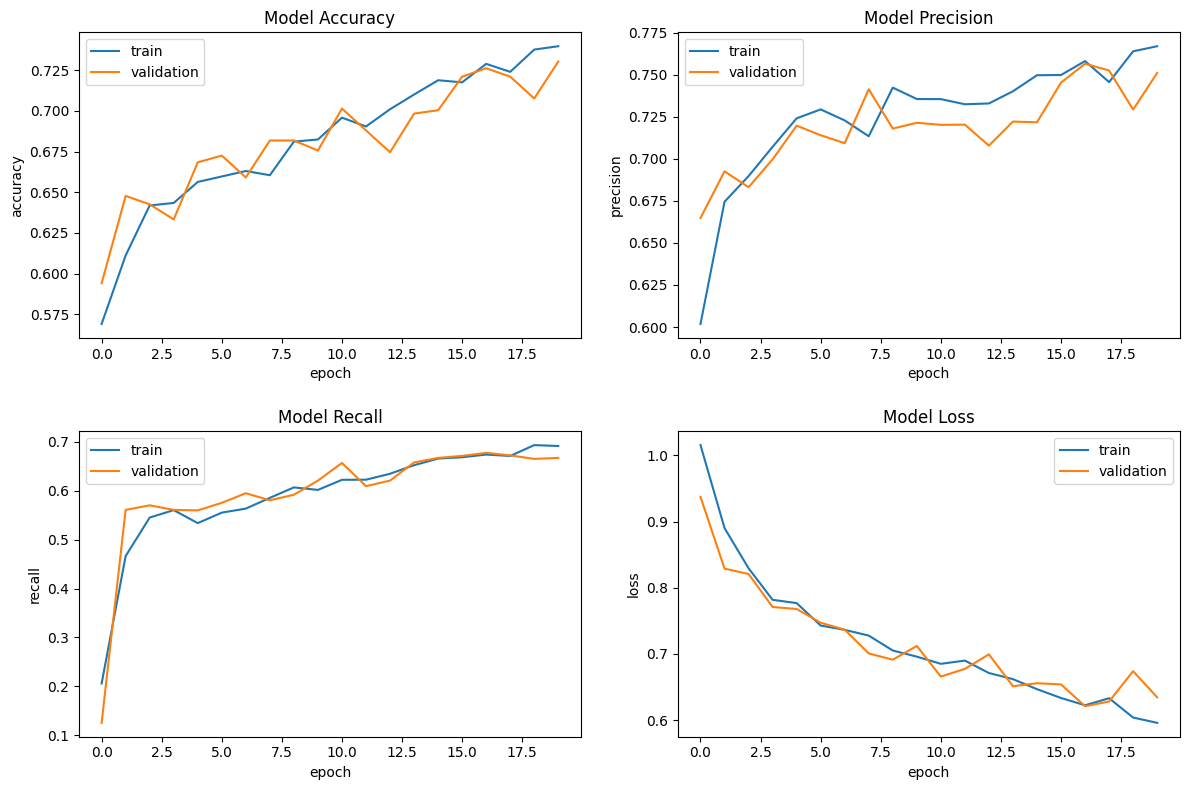

In [32]:
# plot training metrics (accuracy, precision, recall and loss) on charts
plot_training_hist(history)

31/31 [==============================] - 3s 99ms/step
              precision    recall  f1-score   support

    negative       0.54      0.65      0.59       120
     neutral       0.76      0.93      0.84       575
    positive       0.78      0.36      0.49       273

    accuracy                           0.73       968
   macro avg       0.69      0.64      0.64       968
weighted avg       0.74      0.73      0.71       968



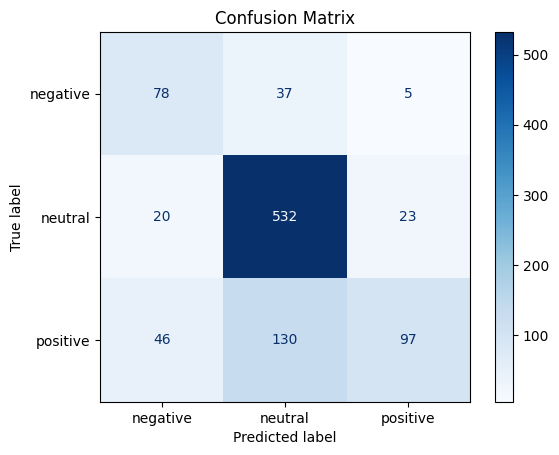

In [33]:
# test the trained model and get reports and confusion matrix
y_pred = model.predict(xtest_pad)
cr = classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2], target_names=('negative', 'neutral', 'positive'))
cm = confusion_matrix(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('negative', 'neutral', 'positive'))
print(cr)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()